In [1]:
from pystac_client import Client

client = Client.open("https://earth-search.aws.element84.com/v1")


In [29]:
bbox = [-75.8,39.2,-75.3,39.7]  # minx, miny, maxx, maxy
time_range = "2021-06-01/2021-06-30"

search = client.search(
    collections=["sentinel-2-l2a"],
    bbox=bbox,
    datetime=time_range,
    query={"eo:cloud_cover": {"lt": 10}}
)
items = list(search.items())


In [30]:
selected_item = items[1]
assets = selected_item.assets
for key, asset in assets.items():
    print(f"{key}: {asset.title}")

aot: Aerosol optical thickness (AOT)
blue: Blue (band 2) - 10m
coastal: Coastal aerosol (band 1) - 60m
granule_metadata: None
green: Green (band 3) - 10m
nir: NIR 1 (band 8) - 10m
nir08: NIR 2 (band 8A) - 20m
nir09: NIR 3 (band 9) - 60m
red: Red (band 4) - 10m
rededge1: Red edge 1 (band 5) - 20m
rededge2: Red edge 2 (band 6) - 20m
rededge3: Red edge 3 (band 7) - 20m
scl: Scene classification map (SCL)
swir16: SWIR 1 (band 11) - 20m
swir22: SWIR 2 (band 12) - 20m
thumbnail: Thumbnail image
tileinfo_metadata: None
visual: True color image
wvp: Water vapour (WVP)
aot-jp2: Aerosol optical thickness (AOT)
blue-jp2: Blue (band 2) - 10m
coastal-jp2: Coastal aerosol (band 1) - 60m
green-jp2: Green (band 3) - 10m
nir-jp2: NIR 1 (band 8) - 10m
nir08-jp2: NIR 2 (band 8A) - 20m
nir09-jp2: NIR 3 (band 9) - 60m
red-jp2: Red (band 4) - 10m
rededge1-jp2: Red edge 1 (band 5) - 20m
rededge2-jp2: Red edge 2 (band 6) - 20m
rededge3-jp2: Red edge 3 (band 7) - 20m
scl-jp2: Scene classification map (SCL)
swi

In [31]:
import stackstac
import xarray as xr

from pyproj import Transformer

# 1. Manually convert Lat/Lon bbox to Web Mercator (EPSG:3857)
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
minx, miny = transformer.transform(bbox[0], bbox[1])
maxx, maxy = transformer.transform(bbox[2], bbox[3])
bounds_3857 = [minx, miny, maxx, maxy]
assets = ["red", "nir"]
# 2. Pass the pre-calculated bounds
da = stackstac.stack(
    items,
    assets=assets,
    bounds=bounds_3857,    # <--- Use 'bounds' (meters), not 'bounds_latlon'
    epsg=3857,
    resolution=10,
    chunksize=1024
)
da = stackstac.stack(
    items,
    assets=["red", "nir"],
    bounds=bbox,     # degrees
    epsg=4326,
    resolution=0.0001,  # ~11 m at mid-latitudes
    chunksize=1024,
)

In [32]:
print(f"Number of items: {len(items)}")
print(f"Bbox content:    {bbox}")

# Check if bbox is actually None
if bbox is None:
    print("⚠️ CRITICAL: Your 'bbox' variable is empty! You need to define it.")
elif len(items) == 0:
    print("⚠️ CRITICAL: Your search returned 0 items. stackstac has nothing to stack.")

Number of items: 2
Bbox content:    [-75.8, 39.2, -75.3, 39.7]


In [33]:
da

<xarray.DataArray 'stackstac-73877f68e213a3799fa0a6d7b57d4871' (time: 2,
                                                                band: 2,
                                                                y: 5000, x: 5001)> Size: 800MB
dask.array<fetch_raster_window, shape=(2, 2, 5000, 5001), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/53)
  * time                                     (time) datetime64[ns] 16B 2021-0...
  * band                                     (band) <U3 24B 'red' 'nir'
  * y                                        (y) float64 40kB 39.7 39.7 ... 39.2
  * x                                        (x) float64 40kB -75.8 ... -75.3
    id                                       (time) <U24 192B 'S2A_18SVJ_2021...
    s2:product_uri                           (time) <U65 520B 'S2A_MSIL2A_202...
    ...                                       ...
    raster:bands                             object 8B {'nodata': 0, 'data_ty...
    proj:shape                               object 8B {10980}
    common_name                              (band) <U3 24B 'red' 'nir'
    center_wavelength                        (band) float64 16B 0.665 0.842
    full_width_half_max                      (band) float64 16B 0.038 0.145
    epsg                                     int64 8B 4326
Attributes:
    spec:        RasterSpec(epsg=4326, bounds=(-75.8, 39.2, -75.2999000000000...
    crs:         epsg:4326
    transform:   | 0.00, 0.00,-75.80|\n| 0.00,-0.00, 39.70|\n| 0.00, 0.00, 1.00|
    resolution:  0.0001

In [34]:
print(da.dims)
print(da.coords)

# specifically:
print("band coord:", da.coords.get("band"))
print("band values:", da.coords.get("band").values)


('time', 'band', 'y', 'x')
Coordinates:
  * time                                     (time) datetime64[ns] 16B 2021-0...
  * band                                     (band) <U3 24B 'red' 'nir'
  * y                                        (y) float64 40kB 39.7 39.7 ... 39.2
  * x                                        (x) float64 40kB -75.8 ... -75.3
    id                                       (time) <U24 192B 'S2A_18SVJ_2021...
    s2:product_uri                           (time) <U65 520B 'S2A_MSIL2A_202...
    view:sun_elevation                       (time) float64 16B 69.37 68.38
    s2:granule_id                            (time) <U62 496B 'S2A_OPER_MSI_L...
    view:sun_azimuth                         (time) float64 16B 135.7 136.9
    s2:datastrip_id                          (time) <U64 512B 'S2A_OPER_MSI_L...
    s2:cloud_shadow_percentage               (time) float64 16B 1.256 0.2355
    mgrs:latitude_band                       (time) <U1 8B 'S' 'T'
    created                 

In [35]:
first = items[0]
list(first.assets.keys())

['aot',
 'blue',
 'coastal',
 'granule_metadata',
 'green',
 'nir',
 'nir08',
 'nir09',
 'red',
 'rededge1',
 'rededge2',
 'rededge3',
 'scl',
 'swir16',
 'swir22',
 'thumbnail',
 'tileinfo_metadata',
 'visual',
 'wvp',
 'aot-jp2',
 'blue-jp2',
 'coastal-jp2',
 'green-jp2',
 'nir-jp2',
 'nir08-jp2',
 'nir09-jp2',
 'red-jp2',
 'rededge1-jp2',
 'rededge2-jp2',
 'rededge3-jp2',
 'scl-jp2',
 'swir16-jp2',
 'swir22-jp2',
 'visual-jp2',
 'wvp-jp2']

In [36]:
red = da.sel(band="red")
nir = da.sel(band="nir")  # or "nir08" if you used that in assets

ndvi = (nir - red) / (nir + red)


In [37]:
%matplotlib inline


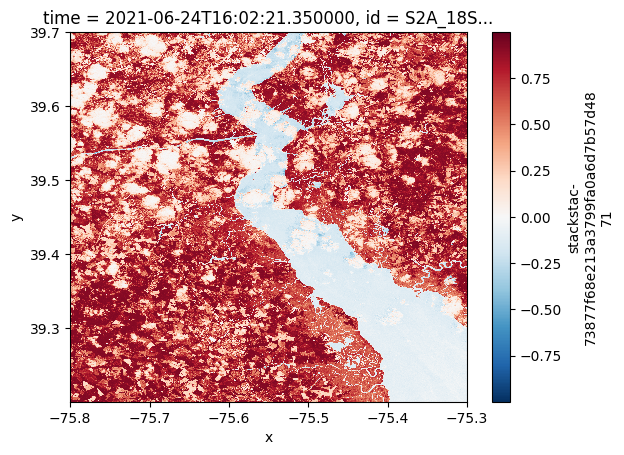

In [38]:
# Single time slice
ndvi.isel(time=0).plot()
